In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch

from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Adam
import random

import torch.nn as nn
import torchvision.models as models
import tqdm
from tqdm import tqdm

In [2]:
from dataset import DDI_Dataset
from sklearn.metrics import roc_auc_score

In [7]:
# import zipfile
# zip_path = '../data/ddidiversedermatologyimages.zip'  
# extract_to = '../data/DDI/images' 

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

In [3]:
metadata = pd.read_csv('../data/DDI/images/ddi_metadata.csv', index_col=0)

In [4]:
metadata.head()

DDI_ID    DDI_file  skin_tone  malignant                          disease
0       1  000001.png         56       True                 melanoma-in-situ
1       2  000002.png         56       True                 melanoma-in-situ
2       3  000003.png         56       True                mycosis-fungoides
3       4  000004.png         56       True  squamous-cell-carcinoma-in-situ
4       5  000005.png         12       True             basal-cell-carcinoma

In [5]:
#Define transformations
#No Lambda function needed as the images are already in RGB format
means = [0.485, 0.456, 0.406]
stds  = [0.229, 0.224, 0.225]
test_transform = T.Compose([
    T.Resize((224, 224)),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=means, std=stds),
    #Data augmentation
    T.RandomHorizontalFlip(),
    T.RandomRotation(10)
])

In [11]:
# #Data preparation
# class DDI_Dataset(Dataset):
#     def __init__(self, root, csv_path=None, transform=None):
#         if csv_path is None:
#             csv_path = os.path.join(root, "ddi_metadata.csv")
#         assert os.path.exists(csv_path), f"Path not found <{csv_path}>."
#         self.root = root
#         self.transform = transform
#         self.annotations = pd.read_csv(csv_path)

#         def is_malignant(x):
#             return x == 1
        
#         m_key = 'malignant'
#         if m_key not in self.annotations:
#             #no  lambda function
#             self.annotations[m_key] = self.annotations['malignancy(malig=1)'].apply(is_malignant)
#         self.annotations.reset_index(drop=True, inplace=True)

#     def __len__(self):
#         return len(self.annotations)

#     def __getitem__(self, index):
#         row = self.annotations.iloc[index]
#         img_path = os.path.join(self.root, row['DDI_file'])
#         image = Image.open(img_path).convert('RGB')
#         if self.transform:
#             image = self.transform(image)
#         target = int(row['malignant']) # 1 if malignant, 0 if benign
#         skin_tone = row['skin_tone'] # Fitzpatrick- 12, 34, or 56
#         return image, target, skin_tone

#     def get_sample_image(self, index=None):
#         if index is None:
#             index = random.randint(0, len(self) - 1)
#         row = self.annotations.iloc[index]
#         img_path = os.path.join(self.root, row['DDI_file'])
#         image = Image.open(img_path).convert('RGB')
#         target = int(row['malignant'])
#         skin_tone = row['skin_tone']
#         return image, target, skin_tone

In [6]:
def display_sample(dataset, index=None):
    image, target, skin_tone = dataset.get_sample_image(index)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(f"Malignant: {target}, Skin Tone: {skin_tone}")
    plt.axis('off')
    plt.show()

In [7]:
# Instantiate the DDI_Dataset class
ddi = DDI_Dataset(root='../data/DDI/images', transform=test_transform)


In [8]:
# Display a random sample image
display_sample(ddi)

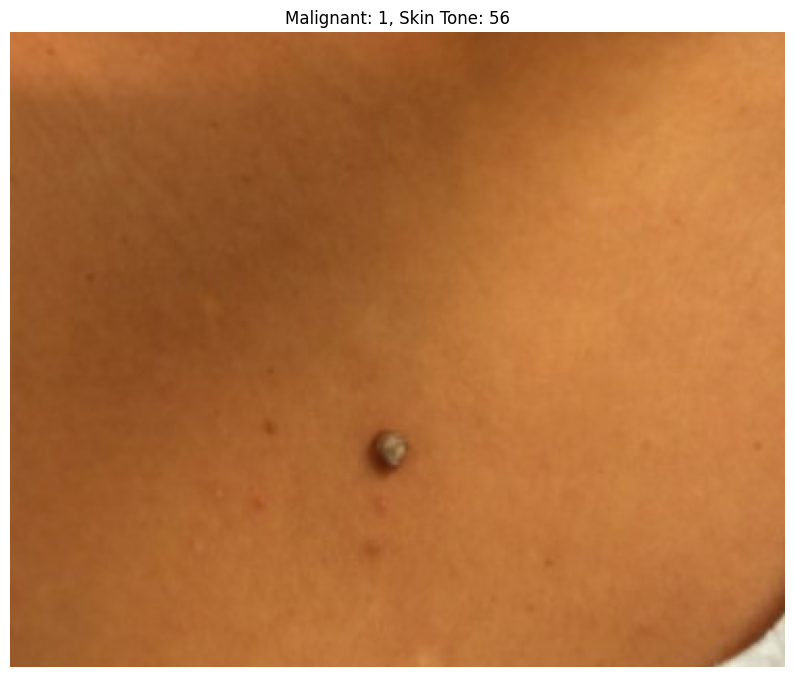

In [9]:
# Display a specific image (e.g., the 10th image in the dataset)
display_sample(ddi, index=11)

In [10]:
#Examine class distribution in the dataset
metadata['malignant'].value_counts()

False    485
True     171
Name: malignant, dtype: int64

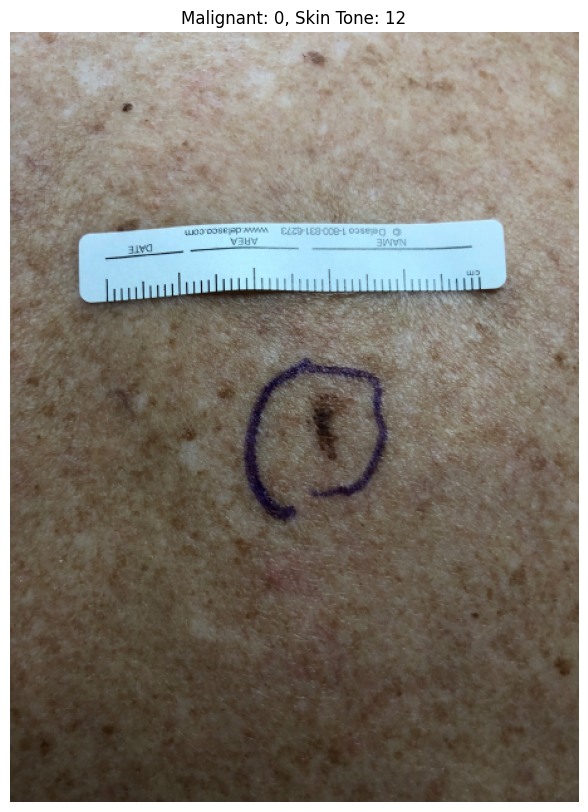

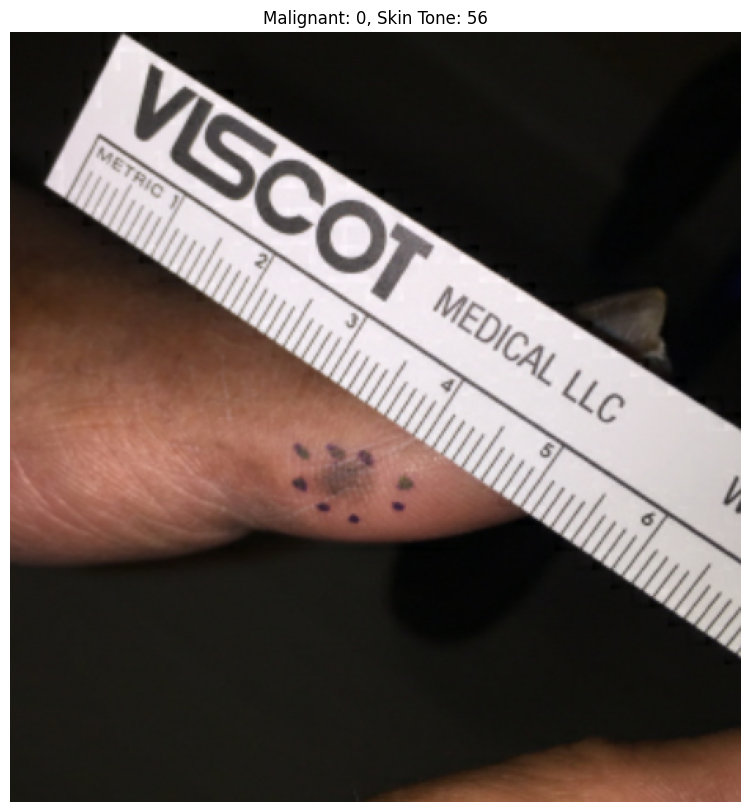

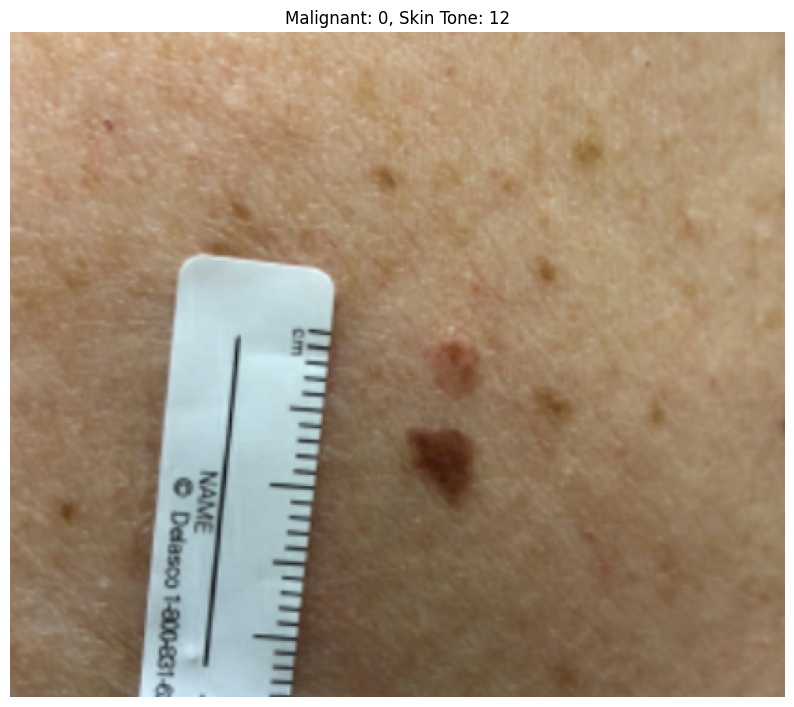

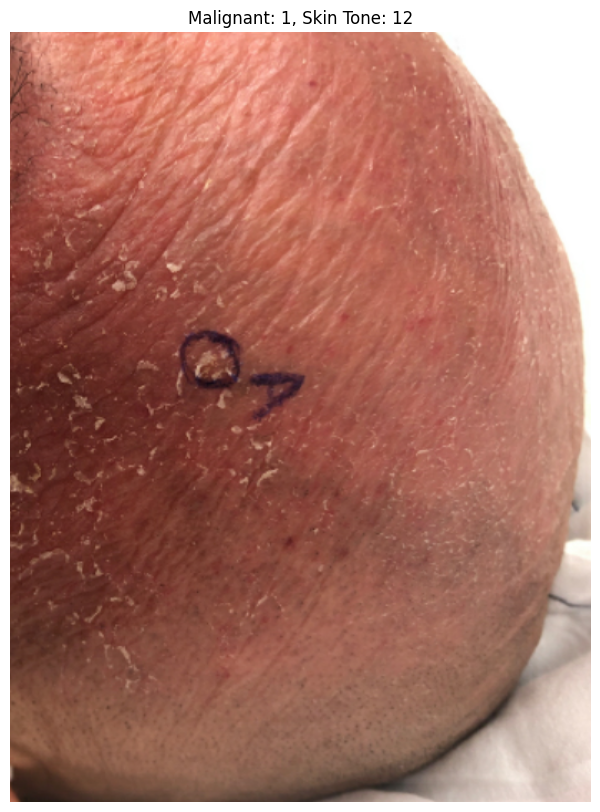

In [11]:
#Check quality of the images
def check_image_quality(dataset):
    for i in range(7):
        display_sample(dataset)

check_image_quality(ddi)

In [18]:
#Class imbalance


In [19]:
# # 3.4 Data Cleaning
# def clean_data(df):
#     # Remove any duplicate entries
#     df_cleaned = df.drop_duplicates()
    
#     # Check for missing values
#     print(f"Missing values:\n{df_cleaned.isnull().sum()}")
    
#     # Remove rows with missing values if any
#     df_cleaned = df_cleaned.dropna()
    
#     # Verify image files exist
#     def image_exists(image_id):
#         return os.path.exists(os.path.join('path/to/your/image/directory', image_id))
    
#     df_cleaned = df_cleaned[df_cleaned['image_id'].apply(image_exists)]
    
#     print(f"\nDataset shape after cleaning: {df_cleaned.shape}")
#     return df_cleaned


In [20]:
# def show_images_by_class(dataset, class_label, num_images=5):
#     fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
#     images = [dataset[i] for i in range(len(dataset)) if dataset[i][1] == class_label]
#     for i in range(num_images):
#         img, label, skin_tone = images[i]
#         img = img.permute(1, 2, 0)  # Change from CxHxW to HxWxC
#         img = img.numpy()  # Convert from PyTorch tensor to NumPy array
#         axes[i].imshow(img)
#         axes[i].set_title(f"Label: {label}, Skin Tone: {skin_tone}")
#         axes[i].axis('off')
#     plt.show()

In [13]:
#Check the sizes of the images

def check_image_sizes(dataset):
    sizes = []
    for i in range(len(dataset)):
        image, _, _ = dataset[i]
        sizes.append(image.size())
    return sizes


In [14]:
check_image_sizes(ddi)

[torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299,

In [15]:
#Splitting the dataset into training, validation, and test sets
def split_dataset(dataset, val_split=0.2, test_split=0.1, shuffle=True, random_seed=42):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    
    val_split = int(np.floor(val_split * dataset_size))
    test_split = int(np.floor(test_split * dataset_size))
    train_split = dataset_size - val_split - test_split

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_indices = indices[:train_split]
    val_indices = indices[train_split:train_split+val_split]
    test_indices = indices[train_split+val_split:]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

dataset_size = len(dataset): It calculates the total number of samples in the dataset.

indices = list(range(dataset_size)): It creates a list of indices from 0 to dataset_size - 1.

split = int(np.floor(val_split * dataset_size)): It calculates the number of samples that should go into the validation set based on the val_split parameter (which is the proportion of the dataset to include in the validation split).

if shuffle: np.random.seed(random_seed); np.random.shuffle(indices): If shuffle is True, it shuffles the indices. This is useful for training models, as you typically want the data to be shuffled. The random_seed parameter ensures that the shuffling is reproducible.

train_indices, val_indices = indices[split:], indices[:split]: It splits the indices into training indices (everything after the first split indices) and validation indices (the first split indices).

train_dataset = Subset(dataset, train_indices); val_dataset = Subset(dataset, val_indices): It creates two new datasets (subsets of the original dataset) using the training and validation indices.

return train_dataset, val_dataset: It returns the training and validation datasets.

In [16]:
train_df, val_df, test_df = split_dataset(ddi, val_split=0.2)

In [17]:
#Plot the train and val dfs

def plot_df_samples(train_df, val_df, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))

    for i in range(num_samples):
        #Plot training samples
        img, label, skin_tone = train_df[i]
        if hasattr(img, 'numpy'):
            img = img.numpy()
        #If the image is in CHW format
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))
        axes[0, i].imshow(img) # dont want to permute the image
        axes[0, i].set_title(f"Training: {label}, {skin_tone}")
        axes[0, i].axis('off')

        #Plot validation samples
        img, label, skin_tone = val_df[i]
        if hasattr(img, 'numpy'):
            img = img.numpy()
        #If the image is in CHW format
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Validation: {label}, {skin_tone}")
        axes[1, i].axis('off')
    
    plt.show()

In [18]:
plot_df_samples(train_df, val_df)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [19]:
#Data augmentation

crop_size = 200


train_transform = T.Compose([
    T.RandomResizedCrop(crop_size),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [20]:
#Create dataloaders function 

train_loader = DataLoader(train_df, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_df, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_df, batch_size=32, shuffle=False, num_workers=4)


batch_size=32: This specifies that each batch that the DataLoader yields should contain 32 samples from the dataset. The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.

A DataLoader is used to load the data in batches during the training or evaluation of a machine learning model. It takes a Dataset object as input and produces an iterator that yields batches of data.

In [21]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [22]:
# 4.3 Model Architecture
class SkinLesionCNN_orig(nn.Module):
    def __init__(self, num_classes=2):
        super(SkinLesionCNN_orig, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [23]:
class SkinLesionModel_resnet(nn.Module):
    def __init__(self, num_classes=2):
        super(SkinLesionModel_resnet, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
# class SkinLesionModel_resnet50(nn.Module):
#     def __init__(self, num_classes=2):
#         super(SkinLesionModel_resnet, self).__init__()
#         self.model = models.resnet50(pretrained=True)
        
#         # Fine-tuning: Unfreeze the last two layers
#         for param in self.model.layer4.parameters():
#             param.requires_grad = True
        
#         # Replace the final fully connected layer
#         self.model.fc = nn.Sequential(
#             nn.Linear(self.model.fc.in_features, 512),  # Change this to match the number of features in the last layer
#             nn.ReLU(),
#             nn.Dropout(0.2),  # Regularization: Dropout
#             nn.Linear(512, num_classes)
#         )
    
#     def forward(self, x):
#         return self.model(x)

In [24]:
model_2 = SkinLesionCNN_orig()
print(model_2)

SkinLesionCNN_orig(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=100352, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [25]:
model_1 = SkinLesionModel_resnet()
print(model_1)

/opt/miniconda3/envs/test1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/test1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SkinLesionModel_resnet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [27]:
# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)
scheduler_1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, mode='min', factor=0.1, patience=10, verbose=True)

In [28]:

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, start_epoch=0, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    best_val_acc = 0.0
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    train_aucs, val_aucs = [], []

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        loop = tqdm(train_loader, total=len(train_loader), leave=True)
        for images, labels, _ in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy())

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, 'checkpoint.pth')

            loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
            loop.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        epoch_auc = roc_auc_score(all_labels, all_preds)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        train_aucs.append(epoch_auc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_all_labels = []
        val_all_preds = []

        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                val_all_labels.extend(labels.cpu().numpy())
                val_all_preds.extend(torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy())

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_epoch_auc = roc_auc_score(val_all_labels, val_all_preds)
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)
        val_aucs.append(val_epoch_auc)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Train AUC: {epoch_auc:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}, Val AUC: {val_epoch_auc:.4f}")

        if scheduler:
            scheduler.step(val_epoch_loss)

        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print("Model saved!")

    return train_losses, train_accs, val_losses, val_accs, train_aucs, val_aucs

In [29]:

def plot_metrics(metric_train, metric_val, metric_name):
    plt.figure(figsize=(10, 7))
    plt.plot(metric_train, label='Train')
    plt.plot(metric_val, label='Validation')
    plt.title(f'Train vs Validation {metric_name} over epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

def plot_training_results(train_losses, train_accs, train_aucs, val_losses, val_accs, val_aucs):
    plot_metrics(train_losses, val_losses, 'Loss')
    plot_metrics(train_accs, val_accs, 'Accuracy')
    plot_metrics(train_aucs, val_aucs, 'AUC')

In [30]:
train_losses, train_accs, val_losses, val_accs, train_aucs, val_aucs = train_model(model_1, train_loader, val_loader, criterion, optimizer_1, scheduler_1, start_epoch=0, num_epochs=50)

Epoch 1/50: 100%|██████████| 15/15 [04:14<00:00, 16.95s/it, loss=0.756]


Epoch 1/50
Train Loss: 0.7635, Train Acc: 0.6891, Train AUC: 0.5189
Val Loss: 0.6109, Val Acc: 0.6641, Val AUC: 0.5764
Model saved!


Epoch 2/50: 100%|██████████| 15/15 [12:42<00:00, 50.83s/it, loss=0.343] 


Epoch 2/50
Train Loss: 0.5582, Train Acc: 0.7630, Train AUC: 0.6526
Val Loss: 0.9115, Val Acc: 0.6641, Val AUC: 0.6334


Epoch 3/50: 100%|██████████| 15/15 [02:48<00:00, 11.25s/it, loss=0.613]


Epoch 3/50
Train Loss: 0.5747, Train Acc: 0.7326, Train AUC: 0.6385
Val Loss: 0.8069, Val Acc: 0.6718, Val AUC: 0.5079
Model saved!


Epoch 4/50: 100%|██████████| 15/15 [02:50<00:00, 11.34s/it, loss=0.459]


Epoch 4/50
Train Loss: 0.5560, Train Acc: 0.7413, Train AUC: 0.6186
Val Loss: 1.4371, Val Acc: 0.7557, Val AUC: 0.6170
Model saved!


Epoch 5/50: 100%|██████████| 15/15 [02:41<00:00, 10.78s/it, loss=0.479]


Epoch 5/50
Train Loss: 0.5557, Train Acc: 0.7630, Train AUC: 0.6492
Val Loss: 0.6393, Val Acc: 0.6947, Val AUC: 0.6173


Epoch 6/50: 100%|██████████| 15/15 [02:47<00:00, 11.15s/it, loss=0.632]


Epoch 6/50
Train Loss: 0.5581, Train Acc: 0.7500, Train AUC: 0.6407
Val Loss: 2.2121, Val Acc: 0.7481, Val AUC: 0.5901


Epoch 7/50: 100%|██████████| 15/15 [02:49<00:00, 11.28s/it, loss=0.42] 


Epoch 7/50
Train Loss: 0.5569, Train Acc: 0.7348, Train AUC: 0.6495
Val Loss: 0.8659, Val Acc: 0.7557, Val AUC: 0.6122


Epoch 8/50: 100%|██████████| 15/15 [02:47<00:00, 11.17s/it, loss=0.521]


Epoch 8/50
Train Loss: 0.5217, Train Acc: 0.7500, Train AUC: 0.7185
Val Loss: 0.6010, Val Acc: 0.7176, Val AUC: 0.5940


Epoch 9/50: 100%|██████████| 15/15 [02:45<00:00, 11.03s/it, loss=0.659]


Epoch 9/50
Train Loss: 0.5293, Train Acc: 0.7587, Train AUC: 0.7049
Val Loss: 0.6907, Val Acc: 0.7176, Val AUC: 0.5840


Epoch 10/50: 100%|██████████| 15/15 [02:48<00:00, 11.21s/it, loss=0.623]


Epoch 10/50
Train Loss: 0.5241, Train Acc: 0.7478, Train AUC: 0.7025
Val Loss: 0.9167, Val Acc: 0.6412, Val AUC: 0.6264


Epoch 11/50: 100%|██████████| 15/15 [02:50<00:00, 11.40s/it, loss=0.351]


Epoch 11/50
Train Loss: 0.5199, Train Acc: 0.7587, Train AUC: 0.7321
Val Loss: 0.6107, Val Acc: 0.7328, Val AUC: 0.5743


Epoch 12/50: 100%|██████████| 15/15 [02:50<00:00, 11.40s/it, loss=0.502]


Epoch 12/50
Train Loss: 0.5211, Train Acc: 0.7609, Train AUC: 0.7048
Val Loss: 0.6284, Val Acc: 0.7176, Val AUC: 0.6383


Epoch 13/50: 100%|██████████| 15/15 [02:42<00:00, 10.81s/it, loss=0.29] 


Epoch 13/50
Train Loss: 0.5034, Train Acc: 0.7826, Train AUC: 0.7415
Val Loss: 0.7205, Val Acc: 0.5878, Val AUC: 0.5985


Epoch 14/50: 100%|██████████| 15/15 [02:43<00:00, 10.90s/it, loss=0.302]


Epoch 14/50
Train Loss: 0.5089, Train Acc: 0.7717, Train AUC: 0.7243
Val Loss: 0.5524, Val Acc: 0.7481, Val AUC: 0.6498


Epoch 15/50: 100%|██████████| 15/15 [02:42<00:00, 10.86s/it, loss=0.676]


Epoch 15/50
Train Loss: 0.4971, Train Acc: 0.7848, Train AUC: 0.7398
Val Loss: 0.6436, Val Acc: 0.7176, Val AUC: 0.6128


Epoch 16/50: 100%|██████████| 15/15 [02:42<00:00, 10.87s/it, loss=0.331]


Epoch 16/50
Train Loss: 0.4960, Train Acc: 0.7609, Train AUC: 0.7558
Val Loss: 0.7553, Val Acc: 0.7176, Val AUC: 0.5843


Epoch 17/50: 100%|██████████| 15/15 [02:43<00:00, 10.87s/it, loss=0.227]


Epoch 17/50
Train Loss: 0.4483, Train Acc: 0.7826, Train AUC: 0.8115
Val Loss: 0.7593, Val Acc: 0.7328, Val AUC: 0.6043


Epoch 18/50: 100%|██████████| 15/15 [02:44<00:00, 10.99s/it, loss=0.683]


Epoch 18/50
Train Loss: 0.4785, Train Acc: 0.7630, Train AUC: 0.7811
Val Loss: 0.8455, Val Acc: 0.6641, Val AUC: 0.6210


Epoch 19/50: 100%|██████████| 15/15 [02:47<00:00, 11.18s/it, loss=0.454]


Epoch 19/50
Train Loss: 0.4736, Train Acc: 0.7891, Train AUC: 0.7884
Val Loss: 0.5810, Val Acc: 0.6870, Val AUC: 0.6301


Epoch 20/50: 100%|██████████| 15/15 [02:48<00:00, 11.22s/it, loss=0.591]


Epoch 20/50
Train Loss: 0.4611, Train Acc: 0.7848, Train AUC: 0.7906
Val Loss: 0.7645, Val Acc: 0.7328, Val AUC: 0.6574


Epoch 21/50: 100%|██████████| 15/15 [02:48<00:00, 11.24s/it, loss=0.601]


Epoch 21/50
Train Loss: 0.5272, Train Acc: 0.7696, Train AUC: 0.7134
Val Loss: 0.6180, Val Acc: 0.7481, Val AUC: 0.6555


Epoch 22/50: 100%|██████████| 15/15 [02:48<00:00, 11.21s/it, loss=0.38] 


Epoch 22/50
Train Loss: 0.4789, Train Acc: 0.7696, Train AUC: 0.7902
Val Loss: 0.6532, Val Acc: 0.7481, Val AUC: 0.6113


Epoch 23/50: 100%|██████████| 15/15 [02:47<00:00, 11.18s/it, loss=0.612]


Epoch 23/50
Train Loss: 0.4636, Train Acc: 0.7804, Train AUC: 0.7792
Val Loss: 0.8326, Val Acc: 0.6412, Val AUC: 0.6589


Epoch 24/50: 100%|██████████| 15/15 [02:49<00:00, 11.31s/it, loss=0.556]


Epoch 24/50
Train Loss: 0.4634, Train Acc: 0.7739, Train AUC: 0.7916
Val Loss: 0.8649, Val Acc: 0.7481, Val AUC: 0.5758


Epoch 25/50: 100%|██████████| 15/15 [02:48<00:00, 11.27s/it, loss=0.511]


Epoch 25/50
Train Loss: 0.4803, Train Acc: 0.7739, Train AUC: 0.7715
Val Loss: 0.6608, Val Acc: 0.7252, Val AUC: 0.6474
Epoch 00025: reducing learning rate of group 0 to 1.0000e-04.


Epoch 26/50: 100%|██████████| 15/15 [02:49<00:00, 11.27s/it, loss=0.492]


Epoch 26/50
Train Loss: 0.4323, Train Acc: 0.8217, Train AUC: 0.8233
Val Loss: 0.5897, Val Acc: 0.6870, Val AUC: 0.6522


Epoch 27/50: 100%|██████████| 15/15 [02:47<00:00, 11.19s/it, loss=0.48] 


Epoch 27/50
Train Loss: 0.4244, Train Acc: 0.8000, Train AUC: 0.8313
Val Loss: 0.6111, Val Acc: 0.7328, Val AUC: 0.6389


Epoch 28/50: 100%|██████████| 15/15 [02:48<00:00, 11.21s/it, loss=0.331]


Epoch 28/50
Train Loss: 0.3958, Train Acc: 0.8174, Train AUC: 0.8690
Val Loss: 0.6150, Val Acc: 0.7252, Val AUC: 0.6637


Epoch 29/50: 100%|██████████| 15/15 [02:47<00:00, 11.14s/it, loss=0.417]


Epoch 29/50
Train Loss: 0.4006, Train Acc: 0.8196, Train AUC: 0.8541
Val Loss: 0.6543, Val Acc: 0.6947, Val AUC: 0.6234


Epoch 30/50: 100%|██████████| 15/15 [02:49<00:00, 11.29s/it, loss=0.581]


Epoch 30/50
Train Loss: 0.3747, Train Acc: 0.8304, Train AUC: 0.8758
Val Loss: 0.6301, Val Acc: 0.7328, Val AUC: 0.6440


Epoch 31/50: 100%|██████████| 15/15 [02:47<00:00, 11.16s/it, loss=0.318]


Epoch 31/50
Train Loss: 0.3721, Train Acc: 0.8391, Train AUC: 0.8772
Val Loss: 0.6250, Val Acc: 0.7176, Val AUC: 0.6631


Epoch 32/50: 100%|██████████| 15/15 [02:47<00:00, 11.18s/it, loss=0.308]


Epoch 32/50
Train Loss: 0.3735, Train Acc: 0.8457, Train AUC: 0.8771
Val Loss: 0.6780, Val Acc: 0.6947, Val AUC: 0.6431


Epoch 33/50: 100%|██████████| 15/15 [02:49<00:00, 11.32s/it, loss=0.276]


Epoch 33/50
Train Loss: 0.3518, Train Acc: 0.8435, Train AUC: 0.8951
Val Loss: 0.6804, Val Acc: 0.7099, Val AUC: 0.6358


Epoch 34/50: 100%|██████████| 15/15 [02:48<00:00, 11.22s/it, loss=0.342]


Epoch 34/50
Train Loss: 0.3477, Train Acc: 0.8587, Train AUC: 0.8954
Val Loss: 0.6697, Val Acc: 0.7099, Val AUC: 0.6192


Epoch 35/50: 100%|██████████| 15/15 [02:49<00:00, 11.27s/it, loss=0.227]


Epoch 35/50
Train Loss: 0.3487, Train Acc: 0.8500, Train AUC: 0.8880
Val Loss: 0.6824, Val Acc: 0.7252, Val AUC: 0.6322


Epoch 36/50: 100%|██████████| 15/15 [02:46<00:00, 11.13s/it, loss=0.0633]


Epoch 36/50
Train Loss: 0.3334, Train Acc: 0.8674, Train AUC: 0.8975
Val Loss: 0.6945, Val Acc: 0.7252, Val AUC: 0.6586
Epoch 00036: reducing learning rate of group 0 to 1.0000e-05.


Epoch 37/50: 100%|██████████| 15/15 [02:50<00:00, 11.34s/it, loss=0.408]


Epoch 37/50
Train Loss: 0.3052, Train Acc: 0.8848, Train AUC: 0.9251
Val Loss: 0.7426, Val Acc: 0.7099, Val AUC: 0.6422


Epoch 38/50: 100%|██████████| 15/15 [02:50<00:00, 11.34s/it, loss=0.876]


Epoch 38/50
Train Loss: 0.3212, Train Acc: 0.8717, Train AUC: 0.9110
Val Loss: 0.7743, Val Acc: 0.7176, Val AUC: 0.6367


Epoch 39/50: 100%|██████████| 15/15 [02:49<00:00, 11.29s/it, loss=0.244]


Epoch 39/50
Train Loss: 0.3187, Train Acc: 0.8783, Train AUC: 0.9135
Val Loss: 0.7626, Val Acc: 0.6718, Val AUC: 0.6198


Epoch 40/50: 100%|██████████| 15/15 [02:47<00:00, 11.19s/it, loss=0.163]


Epoch 40/50
Train Loss: 0.3184, Train Acc: 0.8522, Train AUC: 0.9168
Val Loss: 0.7498, Val Acc: 0.6794, Val AUC: 0.6313


Epoch 41/50: 100%|██████████| 15/15 [02:50<00:00, 11.35s/it, loss=0.406]


Epoch 41/50
Train Loss: 0.3270, Train Acc: 0.8630, Train AUC: 0.9098
Val Loss: 0.7204, Val Acc: 0.7023, Val AUC: 0.6377


Epoch 42/50: 100%|██████████| 15/15 [02:49<00:00, 11.32s/it, loss=0.257]


Epoch 42/50
Train Loss: 0.3082, Train Acc: 0.8609, Train AUC: 0.9224
Val Loss: 0.7386, Val Acc: 0.6565, Val AUC: 0.6419


Epoch 43/50: 100%|██████████| 15/15 [02:47<00:00, 11.19s/it, loss=0.458]


Epoch 43/50
Train Loss: 0.2996, Train Acc: 0.8761, Train AUC: 0.9271
Val Loss: 0.7818, Val Acc: 0.6718, Val AUC: 0.6237


Epoch 44/50: 100%|██████████| 15/15 [02:50<00:00, 11.35s/it, loss=0.238]


Epoch 44/50
Train Loss: 0.2901, Train Acc: 0.8891, Train AUC: 0.9313
Val Loss: 0.7344, Val Acc: 0.6641, Val AUC: 0.6313


Epoch 45/50: 100%|██████████| 15/15 [02:49<00:00, 11.30s/it, loss=0.231]


Epoch 45/50
Train Loss: 0.2881, Train Acc: 0.8957, Train AUC: 0.9273
Val Loss: 0.7965, Val Acc: 0.6565, Val AUC: 0.6198


Epoch 46/50: 100%|██████████| 15/15 [02:50<00:00, 11.35s/it, loss=0.494]


Epoch 46/50
Train Loss: 0.2917, Train Acc: 0.8826, Train AUC: 0.9323
Val Loss: 0.7896, Val Acc: 0.7176, Val AUC: 0.6307


Epoch 47/50: 100%|██████████| 15/15 [02:37<00:00, 10.51s/it, loss=0.0705]


Epoch 47/50
Train Loss: 0.3023, Train Acc: 0.8674, Train AUC: 0.9234
Val Loss: 0.7695, Val Acc: 0.7176, Val AUC: 0.6313
Epoch 00047: reducing learning rate of group 0 to 1.0000e-06.


Epoch 48/50: 100%|██████████| 15/15 [02:39<00:00, 10.60s/it, loss=0.212]


Epoch 48/50
Train Loss: 0.3174, Train Acc: 0.8543, Train AUC: 0.9138
Val Loss: 0.7988, Val Acc: 0.6641, Val AUC: 0.6465


Epoch 49/50: 100%|██████████| 15/15 [02:38<00:00, 10.56s/it, loss=0.118]


Epoch 49/50
Train Loss: 0.2855, Train Acc: 0.8870, Train AUC: 0.9289
Val Loss: 0.8075, Val Acc: 0.6718, Val AUC: 0.6364


Epoch 50/50: 100%|██████████| 15/15 [02:39<00:00, 10.66s/it, loss=0.2]  


Epoch 50/50
Train Loss: 0.3040, Train Acc: 0.8761, Train AUC: 0.9186
Val Loss: 0.7429, Val Acc: 0.6947, Val AUC: 0.6431


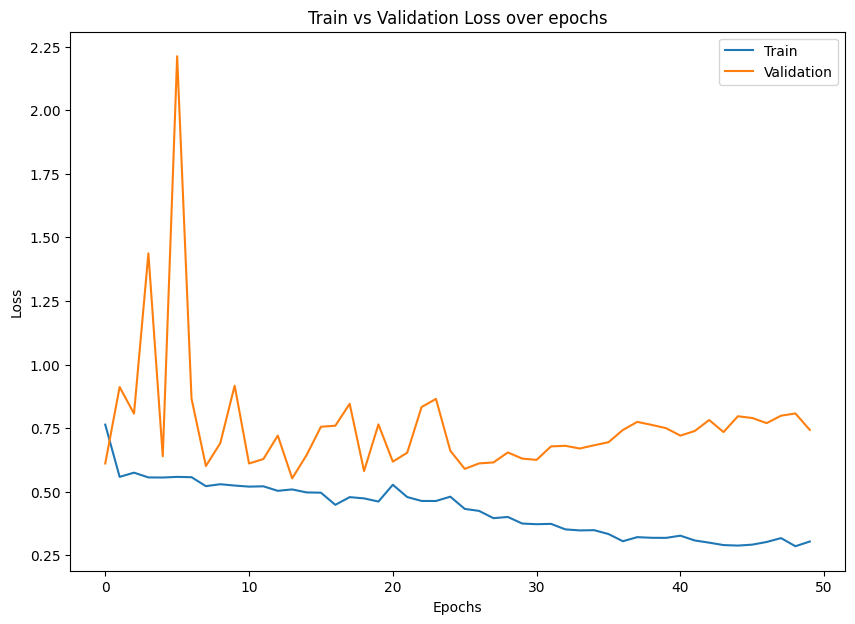

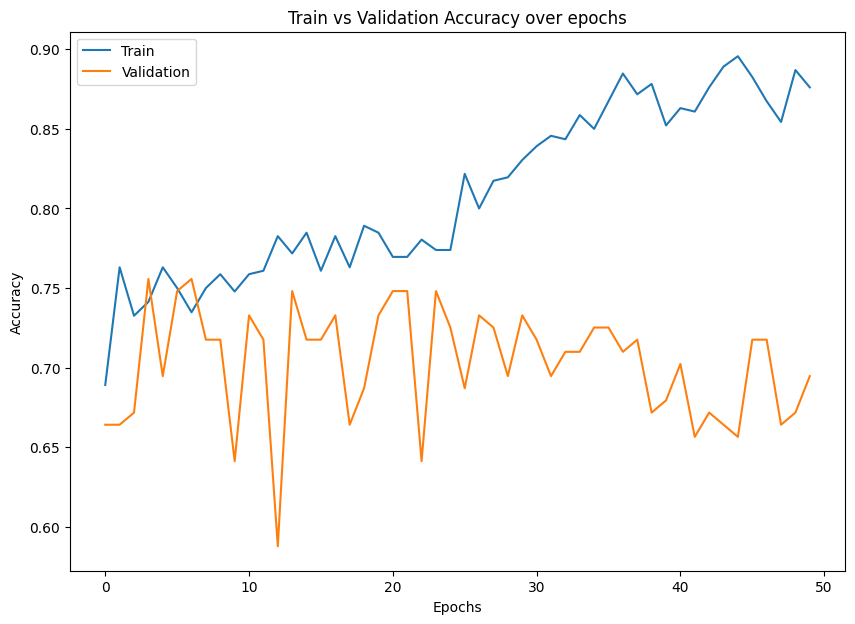

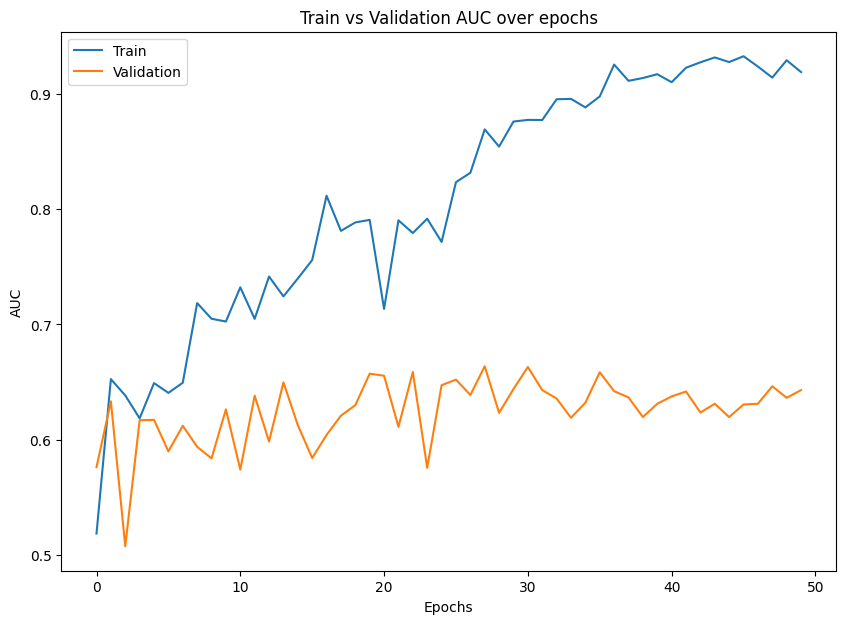

In [31]:
plot_training_results(train_losses, train_accs, train_aucs, val_losses, val_accs, val_aucs)

In [64]:
#Training loop

def train_model(model, train_loader, val_loader, criterion, optimizer, start_epoch=0, num_epochs=1):
    best_val_acc = 0.0
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, total=len(train_loader), leave=True)
        for images, labels, _ in loop:
            images, labels = images.to(device), labels.to(device)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0) 
            #Save checkpoint after each epoch 
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, 'checkpoint.pth')

            # Update the progress bar
            loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
            loop.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        #Calculate average validation loss and accuracy
        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print("Model saved!")

    return train_losses, train_accs, val_losses, val_accs

In [ ]:
# Load the model state
checkpoint = torch.load('checkpoint.pth')
model_1.load_state_dict(checkpoint['model_state_dict'])
optimizer_1.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1
loss = checkpoint['loss']

# Resume training
train_losses, train_accs, val_losses, val_accs = train_model(model_1, train_loader, val_loader, criterion, optimizer_1, start_epoch, num_epochs)

In [65]:
train_losses, train_accs, val_losses, val_accs = train_model(model_1, train_loader, val_loader, criterion, optimizer)

python(27603) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27604) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27605) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27606) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
  0%|          | 0/15 [172:33:18<?, ?it/s]


KeyboardInterrupt: 

class is a wrapper around a pre-trained ResNet-50 model, a popular deep learning model for image classification.

def __init__(self, num_classes=2):: This is the constructor of the SkinLesionModel class. It takes an optional argument num_classes which defaults to 2. This argument specifies the number of output classes the model should have.

super(SkinLesionModel, self).__init__(): This line calls the constructor of the superclass (nn.Module), which is necessary for PyTorch to correctly set up the model.

self.model = models.resnet50(pretrained=True): This line creates a pre-trained ResNet-50 model. The pretrained=True argument means that the model is initialized with weights that were trained on ImageNet, a large dataset of images.

self.model.fc = nn.Linear(self.model.fc.in_features, num_classes): This line replaces the final fully connected layer of the ResNet-50 model with a new fully connected layer that has num_classes output features. This is necessary because the original ResNet-50 model was trained to classify 1000 different classes, but we want our SkinLesionModel to classify a different number of classes (2 by default).

def forward(self, x):: This method defines the forward pass of the model, which is the computation that is performed when you pass an input tensor x to the model.

return self.model(x): This line passes the input tensor x through the ResNet-50 model and returns the output. This output will be a tensor of shape (batch_size, num_classes), where batch_size is the number of samples in the input tensor x, and num_classes is the number of output classes. Each element of this tensor is the model's score for the corresponding class.


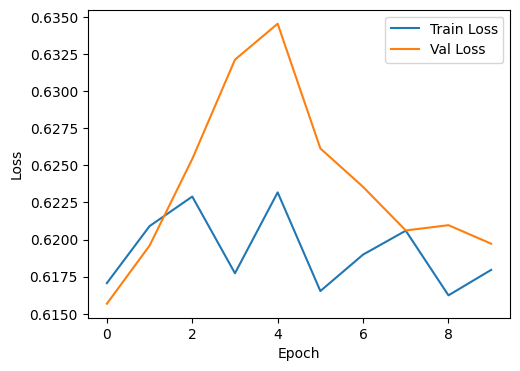

In [62]:
# Plot the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

more epochs (100)
y axis is really tiny range
rounding is happening 
super zoomed in 

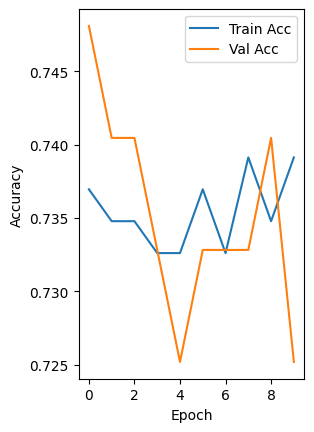

In [54]:
#Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# criterion_1 = nn.CrossEntropyLoss()
# optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [ ]:
# # Save the model and optimizer states at the end of each epoch
# torch.save({
#         'epoch': epoch,
#         'model_state_dict': model_1.state_dict(),
#         'optimizer_state_dict': optimizer_1.state_dict(),
#         'loss': loss,
#     }, f"checkpoint_{epoch}.pth")

In [ ]:
# # Create model and optimizer instances
# model_1 = Model()
# optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=0.01)

# # Load the state_dicts
# checkpoint = torch.load("checkpoint_0.pth")
# model_1.load_state_dict(checkpoint['model_state_dict'])
# optimizer_1.load_state_dict(checkpoint['optimizer_state_dict'])

# # If you want to continue training from this checkpoint, also load the epoch and loss
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [ ]:

# # Assuming test_loader is your test dataset loader
# def evaluate_model(model_path, test_loader):
#     # Load the saved model
#     model = torch.load(model_path)
#     model.eval()

#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for data, labels in test_loader:
#             outputs = model(data)
#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     accuracy = accuracy_score(all_labels, all_preds)
#     precision = precision_score(all_labels, all_preds, average='weighted')
#     recall = recall_score(all_labels, all_preds, average='weighted')
#     f1 = f1_score(all_labels, all_preds, average='weighted')

#     print(f'Model: {model_path}')
#     print(f'Accuracy: {accuracy}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1 Score: {f1}')

# # Now you can evaluate each of your models like this:
# evaluate_model('path_to_your_model_1.pth', test_loader)
# evaluate_model('path_to_your_model_2.pth', test_loader)
# # ... and so on for each model

In [ ]:
def train_and_eval(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=50, lr_min=1e-6, early_stopping=True, save_highest=True, start_epoch=0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    best_val_acc = 0.0
    highest_acc = 0.0  # Track the highest accuracy
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    train_aucs, val_aucs = [], []
    lrs = []

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        loop = tqdm(train_loader, total=len(train_loader), leave=True)
        for images, labels, _ in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track learning rate
            lrs.append(optimizer.param_groups[0]['lr'])

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy())

            loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
            loop.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        epoch_auc = roc_auc_score(all_labels, all_preds)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        train_aucs.append(epoch_auc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_all_labels = []
        val_all_preds = []

        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

                val_all_labels.extend(labels.cpu().numpy())
                val_all_preds.extend(torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy())

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_epoch_auc = roc_auc_score(val_all_labels, val_all_preds)
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)
        val_aucs.append(val_epoch_auc)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Train AUC: {epoch_auc:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}, Val AUC: {val_epoch_auc:.4f}")

        if scheduler:
            scheduler.step(val_epoch_loss)

        # Checkpointing and Early Stopping
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), 'best_model_3.pth')
            print("Model with best validation accuracy saved!")

        if val_epoch_acc > highest_acc and save_highest:
            highest_acc = val_epoch_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_acc': val_epoch_acc,
                'train_accs': train_accs,
                'train_losses': train_losses,
                'val_accs': val_accs,
                'val_losses': val_losses,
                'lrs': lrs,
            }, 'highest_acc_model_w.pth')
            print(f"HIGHEST ACCURACY SURPASSED with {highest_acc:.4f} acc")

        # Early stopping
        if early_stopping and optimizer.param_groups[0]['lr'] < lr_min:
            print(f"EARLY STOPPING! Learning rate below {lr_min}")
            break

    return train_losses, train_accs, val_losses, val_accs, train_aucs, val_aucs

In [ ]:
# def ensemble_predictions(checkpoints, data_loader):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     all_labels = []
#     all_preds = []

#     # models = []
#     # for checkpoint in checkpoints:
#     #     model = type(checkpoint['model_state_dict'])()
#     #     model.load_state_dict(checkpoint['model_state_dict'])
#     #     models.append(model)

#     for images, labels, _ in data_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         preds = np.zeros((len(models), len(labels)))
#         for i, model in enumerate(models):
#             model.eval()
#             model.to(device)
#             outputs = model(images)
#             _, pred = torch.max(outputs, 1)
#             preds[i] = pred.cpu().numpy()

#         all_labels.extend(labels.cpu().numpy().tolist())
#         all_preds.append(preds)

#     all_preds = np.hstack(all_preds)
#     return all_labels, all_preds

# def ensemble_voting(checkpoints, data_loader):
#     all_labels, all_preds = ensemble_predictions(checkpoints, data_loader)
#     all_labels = np.array(all_labels)
#     all_preds = np.array(all_preds)

#     # Majority voting
#     ensemble_preds = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=all_preds)
#     return all_labels, ensemble_preds

# def evaluate_ensemble(checkpoints, data_loader):
#     all_labels, ensemble_preds = ensemble_voting(checkpoints, data_loader)
#     acc = np.mean(all_labels == ensemble_preds)
#     auc = roc_auc_score(all_labels, ensemble_preds)

#     # Evaluate each model individually
#     individual_metrics = []
#     for checkpoint in checkpoints:
#         model = type(checkpoint['model_state_dict'])()
#         model.load_state_dict(checkpoint['model_state_dict'])
#         model_acc = np.mean(all_labels == model.predict(data_loader))
#         model_auc = roc_auc_score(all_labels, model.predict(data_loader))
#         individual_metrics.append((model_acc, model_auc))

#     return acc, auc, individual_metrics

Model A

{'epoch': 19,
 'val_acc': 0.7862595419847328,
 'train_accs': [0.8065217391304348],
 'train_losses': [0.4597551200700843],
 'val_accs': [
  0.7862595419847328],
 'val_losses': [
  0.5306123981949027],
 'train_aucs': [
  0.6720909822277482],
 'val_aucs': [
  0.6455427531837478]}

Model B 

{'epoch': 0,
 'val_acc': 0.6564885496183206,
 'train_accs': [0.508695652173913],
 'train_losses': [0.8760668443596882],
 'val_accs': [0.6564885496183206],
 'val_losses': [0.6443549189858764],
 'train_aucs': [0.5098856627416564],
 'val_aucs': [0.5674651303820497]}

 Model C

 {'epoch': 44,
 'val_acc': 0.7862595419847328,
 'train_accs': [
  0.9],
 'train_losses': [
  0.24759198323540066],
 'val_accs': [
  0.7862595419847328],
 'val_losses': [
  0.7290092028734338],
 'train_aucs': [
  0.855091542943514],
 'val_aucs': [
  0.6455427531837478]}

  Model D

  {'epoch': 8,
 'val_acc': 0.7862595419847328,
 'train_accs': [
  0.8195652173913044],
 'train_losses': [
  0.5028220840122388],
 'val_accs': [
  0.7862595419847328],
 'val_losses': [
  0.5131693864596709],
 'train_aucs': [
  0.7580023891367416],
 'val_aucs': [
  0.6168890236506973]}

  Model E

  {'epoch': 18,
 'val_acc': 0.7709923664122137,
 'train_accs': [
  0.6978260869565217],
 'train_losses': [
  0.6198149396025616],
 'val_accs': [
  0.7709923664122137],
 'val_losses': [
  1.0942159099433257],
 'train_aucs': [
  0.6754065189302519],
 'val_aucs': [
  0.6447847180109157]}

  Model F

  {'epoch': 47,
 'val_acc': 0.7862595419847328,
 'train_accs': [
  0.9391304347826087],
 'train_losses': [
  0.17847494962422744],
 'val_accs': [
  0.7862595419847328],
 'val_losses': [
  0.7965886756664015],
 'train_aucs': [
  0.9427582339891271],
 'val_aucs': [
  0.6932989690721649]}



In [ ]:
#Plot confusion matrix function 

def plot_confusion_matrix(model, data_loader):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels, _ in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
